In [133]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization (for inspection)
import matplotlib.pyplot as plt
import seaborn as sns


# Cleaning


In [134]:
# Load CSV file (specify encoding to avoid UnicodeDecodeError)
df = pd.read_csv("netflix_titles.csv", engine='python', encoding='latin-1')

# Quick look
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
print(df.shape)
df.info()


(8809, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       8809 non-null   object 
 1   type          8809 non-null   object 
 2   title         8809 non-null   object 
 3   director      6175 non-null   object 
 4   cast          7984 non-null   object 
 5   country       7978 non-null   object 
 6   date_added    8799 non-null   object 
 7   release_year  8809 non-null   int64  
 8   rating        8805 non-null   object 
 9   duration      8806 non-null   object 
 10  listed_in     8809 non-null   object 
 11  description   8809 non-null   object 
 12  Unnamed: 12   0 non-null      float64
 13  Unnamed: 13   0 non-null      float64
 14  Unnamed: 14   0 non-null      float64
 15  Unnamed: 15   0 non-null      float64
 16  Unnamed: 16   0 non-null      float64
 17  Unnamed: 17   0 non-null      float64
 18  Unnamed: 18   0 n

In [136]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
Unnamed: 12     8809
Unnamed: 13     8809
Unnamed: 14     8809
Unnamed: 15     8809
Unnamed: 16     8809
Unnamed: 17     8809
Unnamed: 18     8809
Unnamed: 19     8809
Unnamed: 20     8809
Unnamed: 21     8809
Unnamed: 22     8809
Unnamed: 23     8809
Unnamed: 24     8809
Unnamed: 25     8809
dtype: int64

In [137]:
df = df.dropna(subset=["title", "description","cast"])
df["description"] = df["description"].astype(str)
df = df.drop_duplicates(subset=["title","release_year"])

print("Cleaned dataset size:", df.shape)



Cleaned dataset size: (7981, 26)


In [138]:
def extract_top_cast(cast_str, n=3):
    if pd.isna(cast_str):
        return ""
    return " ".join(
        [f"actor_{actor.strip().replace(' ', '')}" 
         for actor in cast_str.split(",")[:n]]
    )

def clean_director(director):
    if pd.isna(director):
        return ""
    return f"director_{director.strip().replace(' ', '')}"


# Text Preprocessing

In [139]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [140]:
df["clean_overview"] = df["description"].apply(clean_text)
df["clean_genre"] = df["listed_in"].apply(clean_text)
df["clean_cast"] = df["cast"].apply(lambda x: extract_top_cast(x, 3))
df["clean_director"] = df["director"].apply(clean_director)



In [141]:
df["movie_profile"] = df["clean_overview"] + " " + df["clean_genre"]+" "+ df["clean_director"]+ " " + df["clean_cast"]


df[["title", "movie_profile"]].head()


,title,movie_profile
1,Blood & Water,crossing path party cape town teen set prove w...
2,Ganglands,protect family powerful drug lord skilled thie...
4,Kota Factory,city coaching center known train india finest ...
5,Midnight Mass,arrival charismatic young priest brings glorio...
6,My Little Pony: A New Generation,equestrias divided brighteyed hero belief eart...


In [142]:
df = df.reset_index(drop=True)


# TF-IDF

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    ngram_range=(1, 2)
)



tfidf_matrix = tfidf.fit_transform(df["movie_profile"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (7981, 23327)


In [145]:
tfidf.get_feature_names_out()[:200]


array(['aaron', 'aaronmoorhead', 'abandon', 'abandoned',
       'abandoned hotel', 'abandoned property', 'abbey', 'abduct',
       'abducted', 'abduction', 'abductor', 'abducts', 'abebrese',
       'abernal', 'abernal actor_diegoluna', 'abhishekchaubey', 'ability',
       'ability bring', 'ability chase', 'able', 'able learn', 'abnormal',
       'aboard', 'aboard spaceship', 'abortion', 'abound',
       'abound detective', 'abroad', 'abrupt', 'abruptly', 'absence',
       'absorbing', 'absurd', 'absurdity', 'abu', 'abu dhabi', 'abuse',
       'abused', 'abusive', 'abusive exboyfriend', 'abusive husband',
       'abyss', 'abyss drama', 'academic', 'academy', 'academy student',
       'acapulco', 'accent', 'accept', 'acceptance', 'accepting',
       'accepts', 'access', 'accident', 'accident action',
       'accident couple', 'accident drama', 'accident leaf',
       'accident sends', 'accident woman', 'accidental', 'accidentally',
       'accidentally kill', 'acclaimed', 'accompanied', 

# PCA

In [146]:
from sklearn.decomposition import TruncatedSVD


In [148]:
n_components = 70

svd = TruncatedSVD(n_components=n_components, random_state=42)
pca_features = svd.fit_transform(tfidf_matrix)



In [149]:
explained_variance = svd.explained_variance_ratio_
print("Total explained variance:", explained_variance.sum())


Total explained variance: 0.10897182991380754


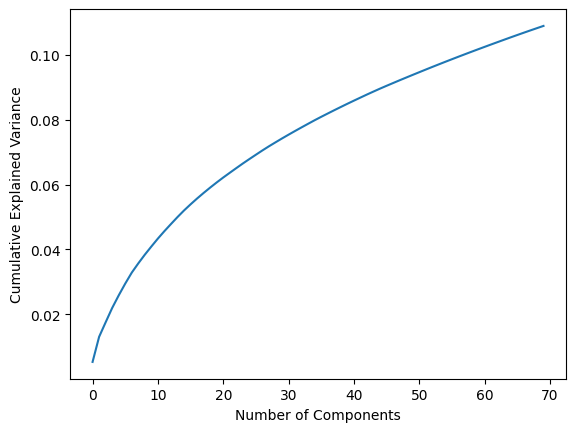

In [150]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# GMM

In [151]:
from sklearn.mixture import GaussianMixture


In [152]:
bic_scores = []
aic_scores = []
k_range = range(1,21) 

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(pca_features)
    bic_scores.append(gmm.bic(pca_features))
    aic_scores.append(gmm.aic(pca_features))


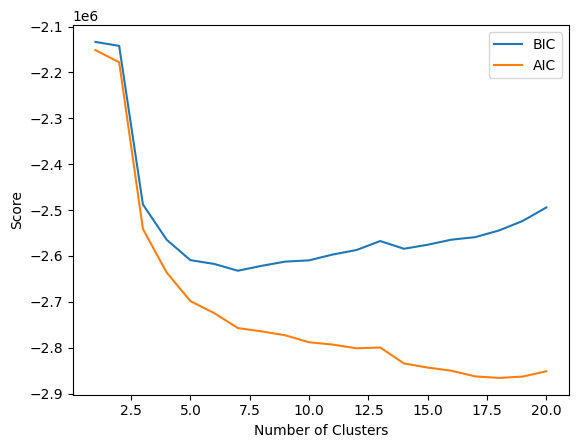

In [153]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [154]:
optimal_k = 8

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(pca_features)


In [155]:
df["gmm_cluster"] = gmm_labels
gmm_probs = gmm.predict_proba(pca_features)
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df[df["gmm_cluster"] == cluster_id]["title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Dark Skies', 'The Stronghold', 'Birth of the Dragon', 'Jaws', 'Jaws 3', 'Jaws: The Revenge', 'Safe House', 'InuYasha the Movie 2: The Castle Beyond the Looking Glass', 'InuYasha the Movie 3: Swords of an Honorable Ruler', 'InuYasha the Movie 4: Fire on the Mystic Island', 'InuYasha the Movie: Affections Touching Across Time', 'Naruto Shippuden the Movie: Blood Prison', 'Naruto ShippÃ»den the Movie: Bonds', 'Naruto ShippÃ»den the Movie: The Will of Fire', 'Naruto Shippuden: The Movie', 'Naruto Shippuden: The Movie: The Lost Tower', 'Naruto the Movie 2: Legend of the Stone of Gelel', 'Naruto the Movie 3: Guardians of the Crescent Moon Kingdom', 'Naruto the Movie: Ninja Clash in the Land of Snow', 'King of Boys']

Cluster 1
['My Little Pony: A New Generation', 'Confessions of an Invisible Girl', 'Go! Go! Cory Carson: Chrissy Takes the Wheel', 'Grown Ups', 'Nightbooks', 'A StoryBots Space Adventure', 'You vs. Wild: Out Cold', 'Little Singham - Black Shadow', 'Firedrake the Sil

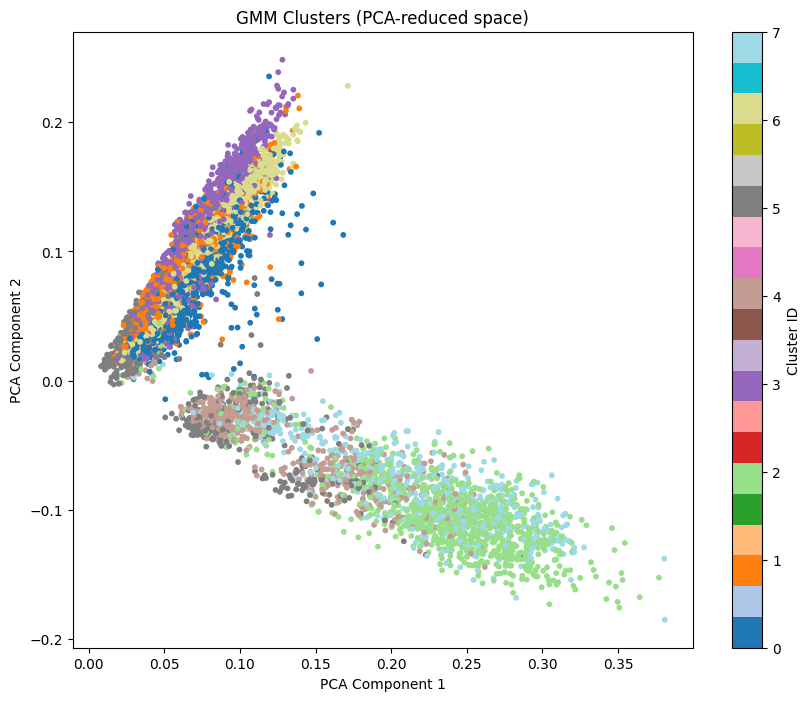

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=df["gmm_cluster"],
    cmap="tab20",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA-reduced space)")
plt.colorbar(label="Cluster ID")
plt.show()


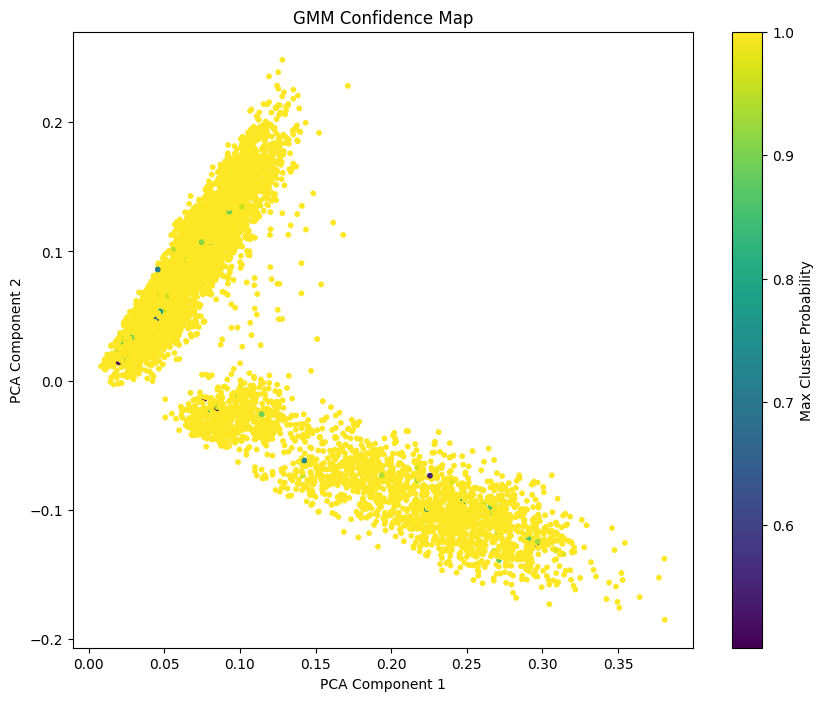

In [159]:
max_probs = gmm.predict_proba(pca_features).max(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=max_probs,
    cmap="viridis",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Confidence Map")
plt.colorbar(label="Max Cluster Probability")
plt.show()


# remove outliers

In [161]:
from sklearn.cluster import DBSCAN


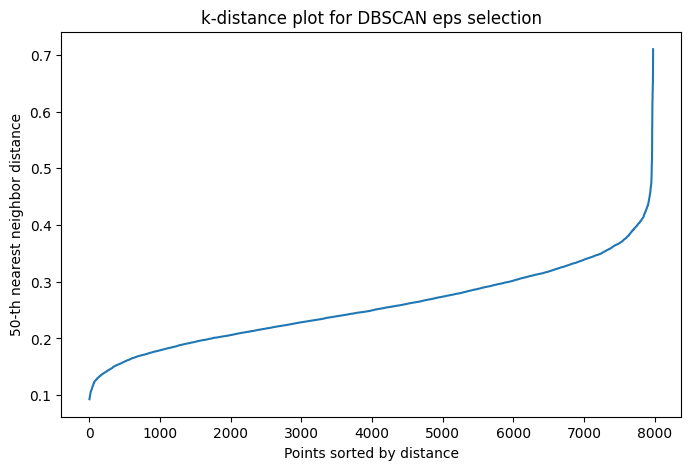

In [162]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 50 # try 30–50
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(pca_features)
distances, indices = neighbors_fit.kneighbors(pca_features)

# distance to kth nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [163]:
dbscan = DBSCAN(
    eps=0.35,
    min_samples=50
)

dbscan_labels = dbscan.fit_predict(pca_features)

df["dbscan_cluster"] = dbscan_labels



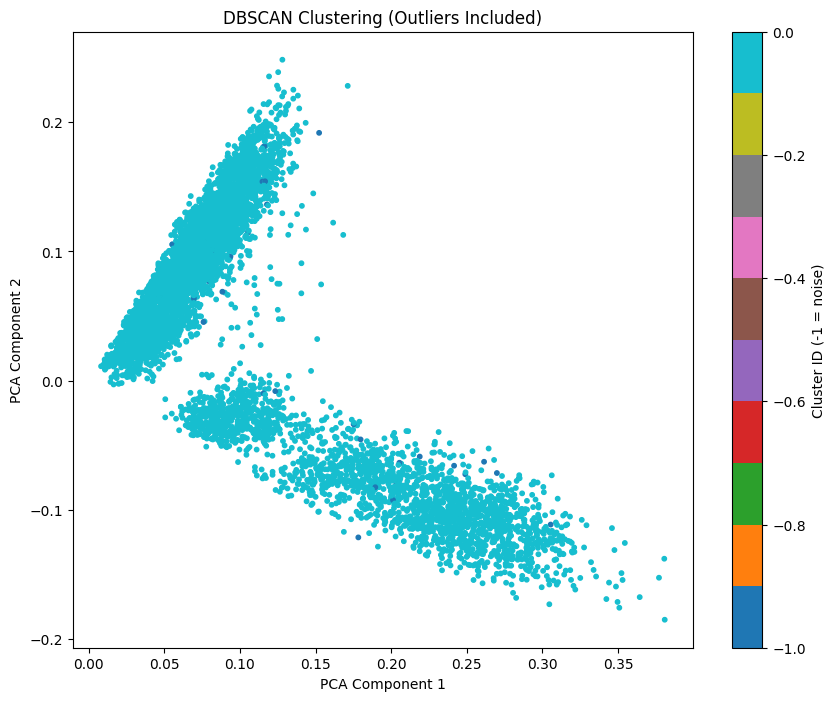

In [165]:
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=dbscan_labels,
    cmap="tab10",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering (Outliers Included)")
plt.colorbar(label="Cluster ID (-1 = noise)")
plt.show()


In [167]:
outliers = df[df["dbscan_cluster"] == -1]
outliers["title"].head(10)


86                                 Kid Cosmic
261                                 Hit & Run
328                               Outer Banks
365    Chhota Bheem And The Crown of Valhalla
366      Chhota Bheem and the Incan Adventure
367       Chhota Bheem and The ShiNobi Secret
369                  Chhota Bheem aur Krishna
370       Chhota Bheem aur Krishna vs Zimbara
373             Chhota Bheem: Bheem vs Aliens
376            Chhota Bheem: Journey to Petra
Name: title, dtype: object

In [168]:
np.unique(dbscan_labels, return_counts=True)


(array([-1,  0]), array([  40, 7941]))

# recommendation

In [172]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df,
    tfidf_matrix,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df.index[df["title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df.loc[idx, "dbscan_cluster"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df.index[df["dbscan_cluster"] != -1].to_numpy()

        similarities = cosine_similarity(
            tfidf_matrix[idx],
            tfidf_matrix[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df.loc[top_indices, ["title", "listed_in", "cast", "director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df.loc[idx, "gmm_cluster"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df.index[
        (df["gmm_cluster"] == cluster_id) &
        (df["dbscan_cluster"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        tfidf_matrix[idx],
        tfidf_matrix[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]

    return df.loc[top_indices, ["title", "listed_in", "cast", "director"]]


In [173]:
# call without passing the cluster array (the function uses df["gmm_cluster"] internally)
recommend_movies(
    "Jaws",
    df,
    tfidf_matrix,
    top_n=10
)


,title,listed_in,cast,director
38,Jaws: The Revenge,"Action & Adventure, Horror Movies, Thrillers","Lorraine Gary, Lance Guest, Mario Van Peebles,...",Joseph Sargent
37,Jaws 3,"Action & Adventure, Horror Movies, Thrillers","Dennis Quaid, Bess Armstrong, Simon MacCorkind...",Joe Alves
1635,Tremors: Shrieker Island,"Action & Adventure, Horror Movies","Michael Gross, Jon Heder, Caroline Langrishe, ...",Don Michael Paul
7221,Schindler's List,"Classic Movies, Dramas","Liam Neeson, Ben Kingsley, Ralph Fiennes, Caro...",Steven Spielberg
2128,Saladin,"Action & Adventure, Classic Movies, Dramas","Ahmad Mazhar, Salah Zo El Faqqar, Nadia Lotfi,...",Youssef Chahine
293,Deep Blue Sea,"Action & Adventure, Horror Movies, Sci-Fi & Fa...","Thomas Jane, Saffron Burrows, Samuel L. Jackso...",Renny Harlin
7379,Superfly,"Action & Adventure, Classic Movies, Dramas","Ron O'Neal, Carl Lee, Sheila Frazier, Julius H...",Gordon Parks
516,Midnight Run,"Action & Adventure, Classic Movies, Comedies","Robert De Niro, Charles Grodin, Yaphet Kotto, ...",Martin Brest
4019,Grandmaster,"International Movies, Thrillers","Mithra Kurian, Anoop Menon, Mohanlal, Narein, ...",B. Unnikrishnan
5779,Bonnie and Clyde,"Action & Adventure, Classic Movies, Dramas","Warren Beatty, Faye Dunaway, Michael J. Pollar...",Arthur Penn


In [174]:
recommend_movies(
    "Naruto Shippuden: The Movie",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
50,Naruto ShippÃ»den the Movie: Bonds,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Noriaki Sugiyam...",Hajime Kamegaki
55,Naruto the Movie 3: Guardians of the Crescent ...,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Yoichi Masukawa...",Toshiyuki Tsuru
54,Naruto the Movie 2: Legend of the Stone of Gelel,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Gamon Kaai, Chie Nakamura, Sho...",Hirotsugu Kawasaki
51,Naruto ShippÃ»den the Movie: The Will of Fire,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Kazuhiko Inoue,...",Masahiko Murata
56,Naruto the Movie: Ninja Clash in the Land of Snow,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Noriaki Sugiyama, Chie Nakamur...",Tensai Okamura
6864,Naruto Shippuden : Blood Prison,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Rikiya Koyama, ...",Masahiko Murata
49,Naruto Shippuden the Movie: Blood Prison,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Rikiya Koyama, ...",Masahiko Murata
53,Naruto Shippuden: The Movie: The Lost Tower,"Action & Adventure, Anime Features, Internatio...","Junko Takeuchi, Chie Nakamura, Satoshi Hino, R...",Masahiko Murata
47,InuYasha the Movie: Affections Touching Across...,"Action & Adventure, Anime Features, Internatio...","Kappei Yamaguchi, Satsuki Yukino, Koji Tsujita...",Toshiya Shinohara
971,New Gods: Nezha Reborn,"Action & Adventure, Anime Features, Internatio...","Yang Tianxiang, Zhang He, Xuan Xiaoming, Li Sh...",Zhao Ji


In [175]:
recommend_movies(
    "Green Lantern",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
6279,Halo: The Fall of Reach,"Action & Adventure, Sci-Fi & Fantasy","Jen Taylor, Steve Downes, Michelle Lukes, Brit...",Ian Kirby
6928,Occupation,"Action & Adventure, Sci-Fi & Fantasy","Daniel Ewing, Temuera Morrison, Stephanie Jaco...",Luke Sparke
5633,Avengers: Infinity War,"Action & Adventure, Sci-Fi & Fantasy","Robert Downey Jr., Josh Brolin, Mark Ruffalo, ...","Anthony Russo, Joe Russo"
5170,Spectral,"Action & Adventure, Sci-Fi & Fantasy","James Badge Dale, Emily Mortimer, Bruce Greenw...",Nic Mathieu
1005,Kingsglaive: Final Fantasy XV,"Action & Adventure, Sci-Fi & Fantasy","Aaron Paul, Lena Headey, Sean Bean, Adrian Bou...",Takeshi Nozue
7626,The Lord of the Rings: The Two Towers,"Action & Adventure, Sci-Fi & Fantasy","Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...",Peter Jackson
5900,Clash of the Titans,"Action & Adventure, Sci-Fi & Fantasy","Sam Worthington, Liam Neeson, Ralph Fiennes, J...",Louis Leterrier
4061,Scorpion King 5: Book of Souls,"Action & Adventure, Sci-Fi & Fantasy","Zach McGowan, Pearl Thusi, Nathan Jones, Peter...",Don Michael Paul
518,Mortal Kombat,"Action & Adventure, Sci-Fi & Fantasy","Christophe Lambert, Robin Shou, Linden Ashby, ...",Paul W.S. Anderson
1907,Seventh Son,"Action & Adventure, Sci-Fi & Fantasy","Jeff Bridges, Ben Barnes, Julianne Moore, Alic...",Sergei Bodrov


In [178]:
recommend_movies(
    "Grown ups",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
7963,You Don't Mess with the Zohan,"Action & Adventure, Comedies","Adam Sandler, John Turturro, Emmanuelle Chriqu...",Dennis Dugan
5918,Coach Carter,"Dramas, Sports Movies","Samuel L. Jackson, Rob Brown, Robert Ri'chard,...",Thomas Carter
5730,Big Fat Liar,"Children & Family Movies, Comedies","Frankie Muniz, Paul Giamatti, Amanda Bynes, Am...",Shawn Levy
6367,Hotel Transylvania 3: Summer Vacation,"Children & Family Movies, Comedies","Adam Sandler, Selena Gomez, Kevin James, Kathr...",Genndy Tartakovsky
5695,Bebe's Kids,Comedies,"Faizon Love, Vanessa Bell Calloway, Wayne Coll...",Bruce W. Smith
5763,Blue Mountain State: The Rise of Thadland,Comedies,"Alan Ritchson, Darin Brooks, James Cade, Rob R...",Lev L. Spiro
5892,Christopher Robin,"Children & Family Movies, Comedies, Dramas","Ewan McGregor, Hayley Atwell, Bronte Carmichae...",Marc Forster
6830,Ms. Mammy,"Comedies, International Movies","Yasmin Abdulaziz, Hassan El Raddad, Ahmed Foua...",Wael Ihsan
2501,Willy and the Guardians of the Lake: Tales fro...,Children & Family Movies,"Csongor Szalay, Anna Kubik, SÃ¡ri Vida, AndrÃ¡...",Zsolt PÃ¡lfi
7647,The Muppets,"Children & Family Movies, Comedies","Jason Segel, Amy Adams, Chris Cooper, Rashida ...",James Bobin


In [179]:
recommend_movies(
    "The Smurfs",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
1802,The Smurfs 2,"Children & Family Movies, Comedies","Neil Patrick Harris, Brendan Gleeson, Jayma Ma...",Raja Gosnell
7407,Teenage Mutant Ninja Turtles,"Children & Family Movies, Comedies","Chris Evans, Sarah Michelle Gellar, Mako Iwama...",Kevin Munroe
7966,"Yours, Mine and Ours","Children & Family Movies, Comedies","Dennis Quaid, Rene Russo, Sean Faris, Katija P...",Raja Gosnell
83,Show Dogs,"Children & Family Movies, Comedies","Will Arnett, Ludacris, Natasha Lyonne, Stanley...",Raja Gosnell
5525,Abominable Christmas,"Children & Family Movies, Comedies","Isabella Acres, Drake Bell, Emilio Estevez, No...",Chad Van De Keere
4928,Puss in Book: Trapped in an Epic Tale,"Children & Family Movies, Comedies","Eric Bauza, Jayma Mays, Maria Bamford, Jeff Be...","Roy Burdine, Johnny Castuciano"
6013,Discovering Bigfoot,Documentaries,Todd Standing,Todd Standing
840,Madagascar 3: Europe's Most Wanted,"Children & Family Movies, Comedies","Ben Stiller, Chris Rock, David Schwimmer, Jada...","Eric Darnell, Tom McGrath, Conrad Vernon"
5775,Bolt,"Children & Family Movies, Comedies","John Travolta, Miley Cyrus, Susie Essman, Mark...","Byron Howard, Chris Williams"
5490,A Holiday Engagement,"Children & Family Movies, Comedies, Romantic M...","Bonnie Somerville, Shelley Long, Jordan Bridge...",Jim Fall


In [190]:
recommend_movies(
    "Demon Slayer: Kimetsu no Yaiba",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
4524,Children of the Whales,"Anime Series, International TV Shows","Natsuki Hanae, Manaka Iwami, Yuuichirou Umehar...",NaN
5332,Your lie in April,"Anime Series, International TV Shows, Romantic...","Natsuki Hanae, Risa Taneda, Ayane Sakura, Ryot...",NaN
4703,Fate/Apocrypha,"Anime Series, International TV Shows","Natsuki Hanae, Maaya Sakamoto, Kouki Uchiyama,...",NaN
3346,Record of Grancrest War,"Anime Series, International TV Shows","Kentaro Kumagai, Akari Kito, Yuichi Nakamura, ...",NaN
1955,Nagi-Asu: A Lull in the Sea,"Anime Series, Romantic TV Shows, Teen TV Shows","Natsuki Hanae, Kana Hanazawa, Ai Kayano, Ryota...",NaN
4198,Mobile Suit Gundam UC,"Anime Series, International TV Shows","Kouki Uchiyama, Ayumi Fujimura, Hiro Shimono, ...",NaN
4406,Saint Seiya: The Lost Canvas,"Anime Series, International TV Shows","Tetsuya Kakihara, Hiro Shimono, Aya Hirano, At...",NaN
2019,Japan Sinks: 2020,"Anime Series, International TV Shows","Reina Ueda, Tomo Muranaka, Yuko Sasaki, Masaki...",NaN
3769,Z Nation,"TV Action & Adventure, TV Comedies, TV Horror","Nat Zang, Russell Hodgkinson, Michael Welch, A...",NaN
3031,Mobile Suit Gundam: Iron-Blooded Orphans,"Anime Series, International TV Shows","Kengo Kawanishi, Yoshimasa Hosoya, Natsuki Han...",NaN


In [198]:
recommend_movies(
    "Django unchained",
    df,
    tfidf_matrix,
    top_n=10
)

,title,listed_in,cast,director
7302,Slow West,"Action & Adventure, Dramas, International Movies","Kodi Smit-McPhee, Michael Fassbender, Ben Mend...",John Maclean
4727,The Hateful Eight,"Action & Adventure, Thrillers","Samuel L. Jackson, Kurt Russell, Jennifer Jaso...",Quentin Tarantino
3517,The Hateful Eight: Extended Version,TV Shows,"Samuel L. Jackson, Kurt Russell, Jennifer Jaso...",Quentin Tarantino
6429,Inglourious Basterds,Action & Adventure,"Brad Pitt, MÃ©lanie Laurent, Christoph Waltz, ...",Quentin Tarantino
7458,The Bounty Hunter,"Action & Adventure, Comedies, Romantic Movies","Jennifer Aniston, Gerard Butler, Jason Sudeiki...",Andy Tennant
6221,Ghost Rider,"Action & Adventure, Sci-Fi & Fantasy","Nicolas Cage, Eva Mendes, Wes Bentley, Sam Ell...",Mark Steven Johnson
7078,Pulp Fiction,"Classic Movies, Cult Movies, Dramas","John Travolta, Samuel L. Jackson, Uma Thurman,...",Quentin Tarantino
315,The Last Boy Scout,"Action & Adventure, Comedies","Bruce Willis, Damon Wayans, Chelsea Field, Nob...",Tony Scott
1720,Free State of Jones,"Action & Adventure, Dramas","Matthew McConaughey, Gugu Mbatha-Raw, Mahersha...",Gary Ross
706,Company of Heroes,"Action & Adventure, Dramas","Tom Sizemore, Chad Michael Collins, Vinnie Jon...",Don Michael Paul
